In [1]:
from itertools import combinations
import random

import numpy as np

np.random.seed(100)
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### 4-1. 数理最適化問題の解き方を理解する
配送Route を「最適化」するために必要な
1. 問題を創る（内定化）
    - 「総移動距離を最小にする」「総配送Cost を最小にする」など最適化したいものを明確にする。
2. 解く
    大まかに２通りの方法がある。
    - 全探索（確実に正しい答えが導き出せるが、非常に計算時間がかかる。）
    - Heuristic（高速計算が可能だが、厳密な最適解を導き出すことはできない）

という Step を整理する。


### 4-2. 数理最適化の出発点である「内定化」を理解しよう
実際に配送Route の最適化問題を内定化していく。
- 目的: 配送Route の総移動距離を最小化する
- 条件: 全倉庫間の距離は既知、各倉庫への訪問回数は１度のみ

[数式](https://boostnote.io/shared/26198401-ab49-428a-b506-25b29607245a)

### 4-3. 全探索を行なってみよう
計算に膨大な時間かかるが、確実に最適解を求めることができる全探索を行なう。

Start からすべての頂点を１度だけ通って再び Start地点に戻ってくるような経路をすべて列挙し、それぞれの経路の距離を求めてその中で最も距離が短くなるような経路を導く。

倉庫の座標
[[ 9 25]
 [68 88]
 [80 49]
 [11 95]
 [53 99]
 [54 67]
 [99 15]
 [35 25]]
倉庫の位置関係


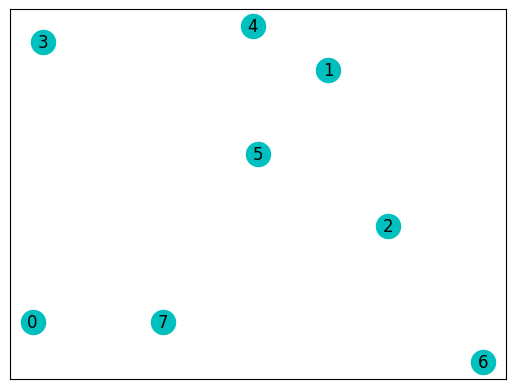

In [2]:
# 各倉庫を頂点とするような Graph を可視化する①

# 頂点を 8 とする
n = 8

# 各地点の座標を読み込む
vertices = pd.read_csv('vertices.csv').values
print("倉庫の座標")
print(vertices)

g = nx.DiGraph()  # Graph の作成
g.add_nodes_from(range(n))  # n個の頂点を Graph に追加
pos = dict(enumerate(zip(vertices[:, 0], vertices[:, 1])))  # 頂点座標の情報を Graph に追加しやすい形に整形

# Graph 描画
nx.draw_networkx(g, pos=pos, node_color='c')
print("倉庫の位置関係")
plt.show()

各頂点間の距離を求める

In [3]:
# 各倉庫を頂点とするような tantraph を可視化する②

# 頂点の距離を Matrix で表す
graph = np.linalg.norm(
    vertices[:, None] - vertices[None, :],
    axis=-1,
)

# わかりやすさのため小数点以下は切り捨て
graph = graph.astype(int)

print("公庫間距離の Matrix")
print(graph)

公庫間距離の Matrix
[[  0  86  74  70  86  61  90  26]
 [ 86   0  40  57  18  25  79  71]
 [ 74  40   0  82  56  31  38  51]
 [ 70  57  82   0  42  51 118  74]
 [ 86  18  56  42   0  32  95  76]
 [ 61  25  31  51  32   0  68  46]
 [ 90  79  38 118  95  68   0  64]
 [ 26  71  51  74  76  46  64   0]]


この Matrix は、例えば１行目2列目は０番目の倉庫（頂点）と１番目の倉庫（頂点）との距離を表す。

1. これら、各頂点間の距離をたどり考え得る全ての巡回Route の総移動距離をすべて計算する。
2. それぞれを比較し、総移動距離が最短になる Route を選択する。

という工程で最短Route を導く。

In [4]:
# すべての巡回Route の移動距離を計算する
from itertools import permutations

src = 0  # 始点（終点）を決める
routes = np.array([*permutations(range(1, 8))]).T  # 経路を全列挙（始点は除いて列挙しておく）

# 経路を出力
m = routes.shape[1]
print(f"経路数: {m}")

# 始点を最初と最後に追加
routes = np.pad(routes, pad_width=((1, 1), (0, 0)), constant_values=src)
print("経路の列挙")
print(routes)

# 各経路について、総移動距離を一括で求める
dist = graph[routes[:-1], routes[1:]].sum(axis=0)
print("各径路の総移動距離")
print(dist)

経路数: 5040
経路の列挙
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 7 7 7]
 [2 2 2 ... 6 6 6]
 ...
 [6 7 5 ... 3 1 2]
 [7 6 7 ... 1 2 1]
 [0 0 0 ... 0 0 0]]
各径路の総移動距離
[440 482 485 ... 471 403 440]


すべての巡回Route の総移動距離が計算できたので、最小のものを選択し最短の総移動距離と、その巡回Route を導出する。

In [5]:
# 最短距離を求める
print(f"最短距離: {dist.min()}")

最短距離: 314


In [6]:
# 最短の巡回Route を求める
i = np.argsort(dist)  # .argsort(): 配列の要素を Sort した時の Indexes を返す。
routes = routes[:, i]
dist = dist[i]
print("経路を短い順に並び替える")
print(dist)

path = routes[:, 0]
print(f"最短経路: {path}")
print(f"最短距離: {dist[0]}")

経路を短い順に並び替える
[314 314 336 ... 618 620 620]
最短経路: [0 3 4 1 5 2 6 7 0]
最短距離: 314


最短Route を可視化する

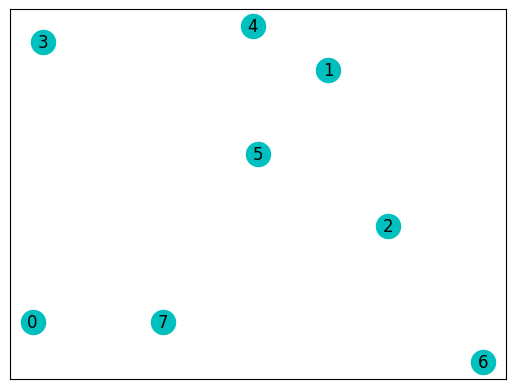

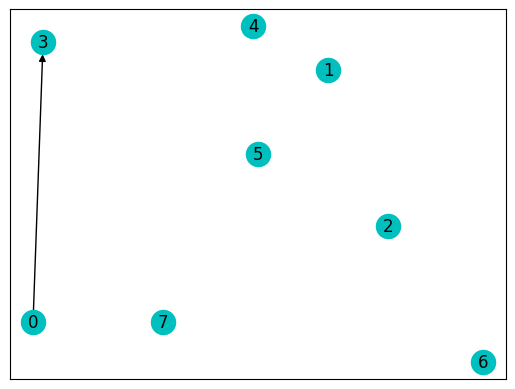

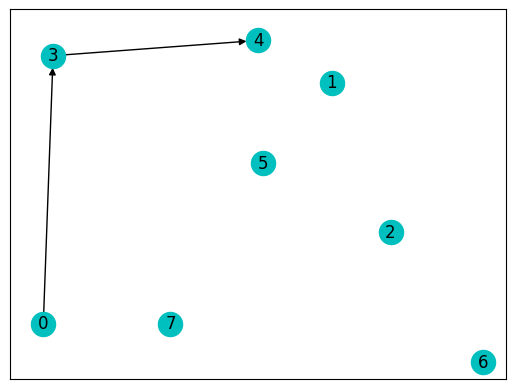

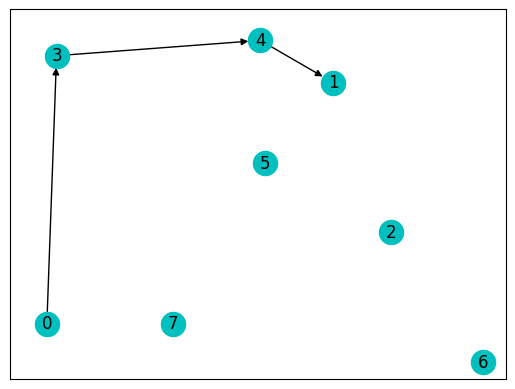

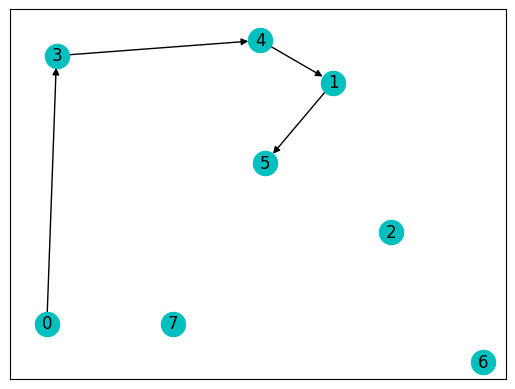

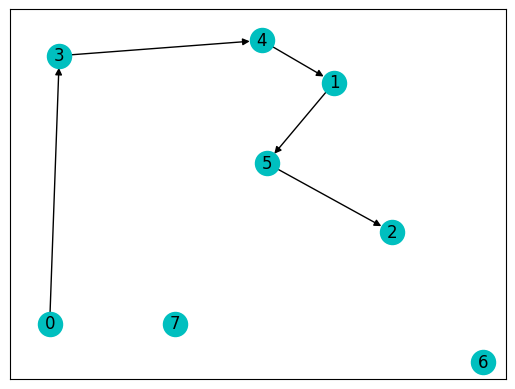

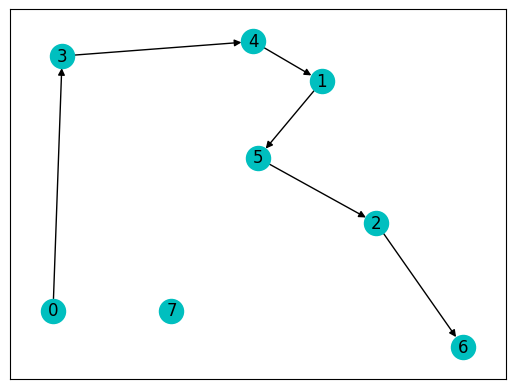

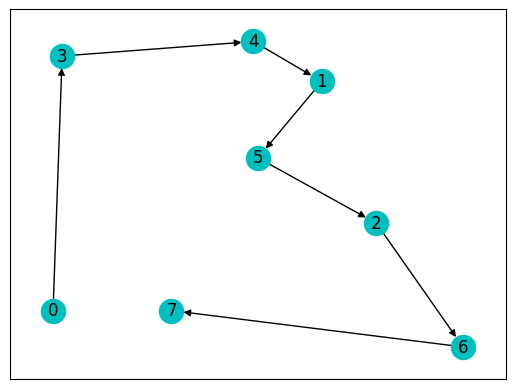

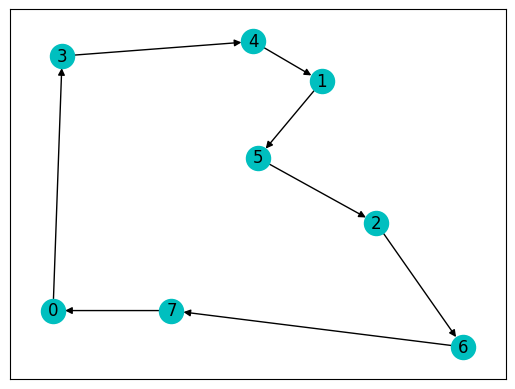

In [7]:
# 最短の巡回Route を可視化する
for i in range(n):
    nx.draw_networkx(g, pos=pos, node_color='c')
    plt.show()
    g.add_edge(path[i], path[i + 1])
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()

for i in range(n):
    g.remove_edge(path[i], path[i + 1])

最短巡回Route を導出することができた。
ただし、「全探索」では倉庫の数が増加していくと、それに伴って計算時間が膨大になる。
そこで、効率的に最短Route を導出する方法を検討していく。

### 4-4. Algorithm による問題の解き方を理解しよう

In [8]:
# １から100までの和を求める

# n を100とする
n = 100
s = sum(i for i in range(1, n + 1))
print(f"和: {s}")

和: 5050


一般的な PC に搭載されている CPU で、Python の処理速度は１秒間に 10^7回程度。
上記より、倉庫の数が仮に15になると、全探索では最適解を求めるのに少なくtも３時間以上の計算時間が必要になってします。
そこで、効率よく計算する Algorithm を考える必要がある。

In [9]:
# 1 から 100 までの和を１回の掛け算で求める
n = 100
s = (1 + n) * n // 2
print(f"和: {s}")

和: 5050


In [10]:
# 1 から 10000 までの和を１回の掛け算で求める
n = 10_000
s = (1 + n) * n // 2
print(f"和: {s}")

和: 50005000


### 4-5. 動的計画法によって厳密解を求める方法を学ぼう
最短の巡回Route の計算を「動的計画法（DP: Dynamic Programing）」という Algorithm によって効率化してみる。

### 4-6. 動的計画法の Source-code を理解しよう

最短Route を効率的に求められるように必要な Class を定義する。

In [11]:
# 動的計画法（DP）と全探索を計算して、比較するために必要な Class を定義する①

inf = float('inf')


class Graph:
    """
    巡回すべき倉庫の情報を与えることで、それぞれの倉庫間の移動距離を計算し、最短Route を計算する。
    """

    class Edge:
        """
        辺の情報（頂点である倉庫と倉庫の間の情報）を持つ。
        """

        def __init__(self, weight=1, **args):
            self.weight = weight  # 倉庫間の移動距離を格納する。

        def __repr__(self):
            return f'{self.weight}'

    def __init__(self, n):
        self.N = n  # Graph の頂点数（すなわち倉庫の数）を示す。
        self.edges = [{} for _ in range(n)]

    # 辺を追加
    def add_edge(self, u, v, **args):
        """頂点u, v 間に辺を追加する。"""
        self.edges[u][v] = self.Edge(**args)

    @classmethod
    def from_csv(cls, path):
        nodes = pd.read_csv(path).values
        n = nodes.shape[0]
        print(f'頂点数: {n}')
        weights = cls.weights_from_nodes(nodes)

        g = cls(n)
        g.generate_network(nodes)

        for u in range(n):
            for v in range(n):
                g.add_edge(u, v, weight=weights[u, v])
        return g

    @staticmethod
    def generate_nodes(n):
        nodes = np.random.randint(low=0, high=100, size=(n, 2))
        return nodes

    def generate_network(self, nodes):
        n = len(nodes)
        network = nx.DiGraph()
        network.add_nodes_from(range(n))
        pos = dict(
            enumerate(zip(nodes[:, 0], nodes[:, 1]))
        )
        nx.draw_networkx(network, pos=pos, node_color='c')
        self.network = network
        self.pos = pos
        return network

    @staticmethod
    def weights_from_nodes(nodes):
        return np.linalg.norm(
            nodes[:, None] - nodes[None, :],
            axis=-1,
        ).astype(np.int64)

    # Random に辺を生成する関数(csv以外のパターンも作成したい場合に使用)
    def generate_edges(self):
        """全頂点間に Random な長さの辺を貼る。"""
        random.seed(0)
        for u, v in combinations(range(self.N), 2):
            weight = random.randint(1, 100)
            self.add_edge(u, v, weight=weight)
            self.add_edge(v, u, weight=weight)
        for u in range(self.N):
            self.add_edge(u, u, weight=0)

    # ルートの総距離を計算(全探索用)
    def calculate_dist(self, route):
        """経路を渡すと距離を計算して返す。"""
        n = self.N
        source = route[0]
        route += [source]
        return sum(
            self.edges[route[i]][route[i + 1]].weight
            for i in range(n)
        )

    def show_path(self, path):
        n = self.N
        network = self.network
        pos = self.pos
        for i in range(n):
            network.add_edge(path[i], path[i + 1])
        nx.draw_networkx(
            network,
            pos=pos,
            node_color='c',
        )
        plt.show()
        self.remove_edges()

    def remove_edges(self):
        network = self.network
        network.remove_edges_from(
            list(network.edges)
        )




In [12]:
# 動的計画法(DP) と全探索を計算して、比較するために必要な Class を定義する②

class TSPBruteFore(Graph):
    # 全探索Algorithm （DP Algorithm との比較用に、numpy を使わず実装）
    def __call__(self, src=0):
        n = self.N
        stack = [([src], 1 << src)]
        dist = float('inf')
        calc_count = 0
        while stack:
            route, visited = stack.pop()
            if visited == (1 << n) - 1:
                calc_count += 1
                d = self.calculate_dist(route)
                if d >= dist: continue
                dist = d
                res_route = route

            for i in range(n):
                if i == src or visited >> i & 1: continue
                nxt_route = route.copy()
                nxt_route.append(i)
                stack.append((nxt_route, visited | (1 << i)))

        print(f"計算回数: {calc_count}")
        return dist, res_route

In [13]:
# 動的計画法（DP）と全探索を計算して、比較するために必要な Class を定義する③

class TSPDP(Graph):
    # DP-Algorithm
    def __call__(self, src=0):
        # DP による最適解検索を実施。
        n = self.N
        dp = [[(inf, None)] * n for _ in range(1 << n)]
        dp[1][src] = (0, None)
        calc_count = 0
        for s in range(1 << n):  # range(1<<n): すべての頂点集合を列挙
            for v in range(n):
                if s >> v & 1: continue  # s>> v & 1: 点集合 s に頂点 v が含まれているかを判定
                t = s | (1 << v)  # t は s に v を追加した集合  # 頂点集合 s に
                for u in range(n):
                    if ~s >> u & 1: continue  # ~s >> u & 1: 頂点集合 s に頂点 u が含まれていないかを判定
                    d = dp[s][u][0] + self.edges[u][v].weight
                    if d >= dp[t][v][0]:
                        continue
                    dp[t][v] = (d, u)
                    calc_count += 1

        print(f"計算回数: {calc_count}")

        # 経路の復元。
        dist = inf
        predecessor = []
        for u in range(1, n):
            s = (1 << n) - 1
            d = dp[s][u][0] + self.edges[u][src].weight
            if d >= dist: continue
            dist = d
            predecessor = [src]
            while True:
                v = u
                predecessor.append(v)
                u = dp[s][v][1]
                if u is None: break
                s &= ~(1 << v)

        return dist, predecessor[::-1]

Graph class を定義し、倉庫（頂点）の座標を CSV file から読み取る。

DP
頂点数: 11
全探索
頂点数: 11


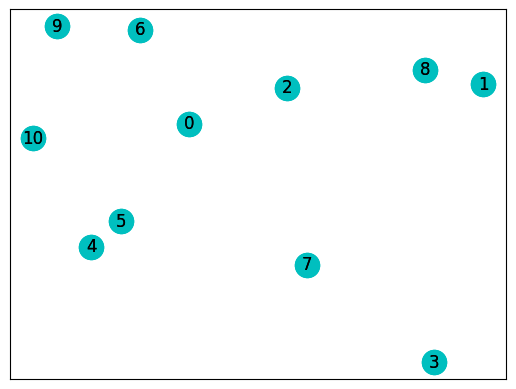

In [14]:
# Graph class を定義して、倉庫距離を与える

print("DP")
g1 = TSPDP.from_csv('4_6_nodes.csv')
print("全探索")
g2 = TSPBruteFore.from_csv('4_6_nodes.csv')

In [15]:
%%time
# 動的計画(DP)によって最短Route を求める
d, path = g1(src=0)
print(f"距離: {d}")
print(f"経路: {path}")

計算回数: 10633
距離: 331
経路: [0, 6, 9, 10, 4, 5, 7, 3, 1, 8, 2, 0]
CPU times: total: 31.2 ms
Wall time: 177 ms


- 最適な計算回数
- 経路
- 総移動距離

が求まる。

この結果が正しいか、また計算時間の比較を行なうために、全探索の結果を確認する。

In [16]:
%%time
# 全探索によって最短Route を求める
d, path = g2(src=0)
print(f"距離: {d}")
print(f"経路: {path}")

計算回数: 3628800
距離: 331
経路: [0, 6, 9, 10, 4, 5, 7, 3, 1, 8, 2, 0]
CPU times: total: 26.6 s
Wall time: 36.5 s


全探索と動的計画法で求めた巡回Route が同じになったことを確認。
また、動的計画法は全探索の約100分の1未満の計算時間で最短距離を求めれることを確認。

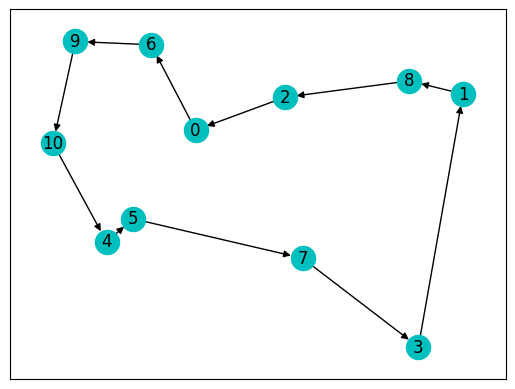

In [17]:
# 経路の出力
g2.show_path(path)